In [1]:
import json
import numpy as np

def load_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data ## I'll make this loop through but for now

def extract_joint_positions(json_data):
    positions = []
    for frame in json_data['tracking']:
        player_data = frame['data']['player']
        
        r_shoulder = np.array(player_data['R_SHOULDER'])
        r_elbow = np.array(player_data['R_ELBOW'])
        r_wrist = np.array(player_data['R_WRIST'])

        positions.append((r_shoulder, r_elbow, r_wrist)) ## Should probably save this as a np.array but this works for now
    
    return positions

def calculate_limb_vectors(ith_position):
    r_shoulder, r_elbow, r_wrist = ith_position
    upper_arm_vector =  r_elbow - r_shoulder
    forearm_vector = r_wrist - r_elbow
    return upper_arm_vector, forearm_vector

def frame_to_rotation(positions):

    prev_upper_arm, prev_forearm = calculate_limb_vectors(positions[0])  #initing the prev variable
    prev_upper_arm, prev_forearm = prev_upper_arm / np.linalg.norm(prev_upper_arm), prev_forearm / np.linalg.norm(prev_forearm)

    rot_matrices = []
    for i in range(1, len(positions)):
        upper_arm, forearm = calculate_limb_vectors(positions[i])
        
        forearm = forearm / np.linalg.norm(forearm)
        upper_arm = upper_arm / np.linalg.norm(upper_arm)
        
        upper_arm_cross_prod = np.cross(prev_upper_arm, upper_arm )
        upper_arm_cos = np.dot(prev_upper_arm, upper_arm)
        upper_arm_sin = np.linalg.norm(upper_arm_cross_prod)

        upper_arm_kmat = np.array([[0, -upper_arm_cross_prod[2], upper_arm_cross_prod[1]], 
                        [upper_arm_cross_prod[2], 0, -upper_arm_cross_prod[0]], 
                        [-upper_arm_cross_prod[1], upper_arm_cross_prod[0], 0]])
        
        upper_arm_rotation_matrix = np.eye(3) + upper_arm_sin*upper_arm_kmat + (1-upper_arm_cos)*upper_arm_kmat.dot(upper_arm_kmat)

        forearm_cross_prod = np.cross(prev_forearm, forearm)
        forearm_cos = np.dot(prev_forearm, forearm)
        forearm_sin = np.linalg.norm(forearm_cross_prod)

        forearm_kmat = np.array([[0, -forearm_cross_prod[2], forearm_cross_prod[1]], 
                        [forearm_cross_prod[2], 0, -forearm_cross_prod[0]], 
                        [-forearm_cross_prod[1], forearm_cross_prod[0], 0]])
        
        forearm_rotation_matrix = np.eye(3) + forearm_sin*forearm_kmat + (1-forearm_cos)*forearm_kmat.dot(forearm_kmat)
        rot_matrices.append((upper_arm_rotation_matrix, forearm_rotation_matrix))

        prev_upper_arm, prev_forearm = upper_arm, forearm
        
    return rot_matrices

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

In [3]:
import os
import json
import pandas as pd

from preprocess.utils import *

sample_path = os.path.join(ROOT, "../", "../" ,"basketball", "freethrow", "data", "P0001", "BB_FT_P0001_T0001.json")

load_json(sample_path)

def extract_joint_positions(json_data):
    positions = []
    for frame in json_data['tracking']:
        player_data = frame['data']['player']
        
        r_shoulder = np.array(player_data['R_SHOULDER'])
        r_elbow = np.array(player_data['R_ELBOW'])
        r_wrist = np.array(player_data['R_WRIST'])

        positions.append((r_shoulder, r_elbow, r_wrist)) ## Should probably save this as a np.array but this works for now
    
    return positions


frame_to_rotation(extract_joint_positions(load_json(sample_path)))

[(array([[ 1.00000000e+00,  2.57283565e-07,  1.55546502e-06],
         [-2.57281146e-07,  1.00000000e+00, -1.55546542e-06],
         [-1.55546542e-06,  1.55546502e-06,  1.00000000e+00]]),
  array([[ 1.00000000e+00, -6.02672583e-07,  3.74595810e-13],
         [ 6.02672583e-07,  1.00000000e+00, -1.24311484e-06],
         [ 3.74595680e-13,  1.24311484e-06,  1.00000000e+00]])),
 (array([[ 1.00000000e+00,  9.82055350e-07,  5.88260647e-06],
         [-9.82023633e-07,  1.00000000e+00, -5.39159226e-06],
         [-5.88261176e-06,  5.39158648e-06,  1.00000000e+00]]),
  array([[ 1.00000000e+00,  8.84127171e-15,  2.70028983e-07],
         [ 8.84127171e-15,  1.00000000e+00, -6.54838678e-08],
         [-2.70028983e-07,  6.54838678e-08,  1.00000000e+00]])),
 (array([[ 1.00000000e+00,  8.62736336e-07,  4.96674458e-06],
         [-8.62724002e-07,  1.00000000e+00, -2.48337497e-06],
         [-4.96674672e-06,  2.48337068e-06,  1.00000000e+00]]),
  array([[ 1.00000000e+00,  8.84127171e-15, -2.70028983e-0

In [33]:
def json_to_rot_matrices(file_path):
    
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    positions = extract_joint_positions(data)
    rotation_matrices = frame_to_rotation(positions)
    
    return rotation_matrices

def convert_to_rot_matrices(folder_path):
    dict_output = {}

    for _, filename in enumerate(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        dict_output[filename] = json_to_rot_matrices(file_path)
    
    return dict_output


    



'c:\\Users\\User\\OneDrive\\Desktop\\DS Practice\\Sport\\SPL-Open-Data-Rahul\\src\\kinematic chains'

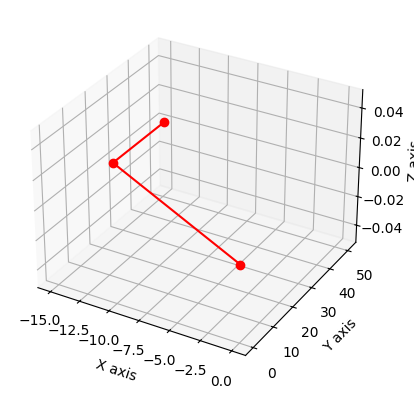

In [16]:


def json_to_tab(file_path, start_dict = None):
    """
    func takes the json data and then returns a dict with 90 keys with each key having exactly 240 values

    Args:
        file_path (str): Pretty obvious
        start_dict (dict): This is the dict that we append more data to. This could be empty #TODO: Add functionality for start_dict empty
    Returns:
        start_dict (dict): start_dict and then for each key append info to it.  (Index is participant id-trial number id-frame id) 
    """

    if start_dict == None:
        start_dict = {}

    with open(file_path, 'r') as file:
        data = json.load(file)
    
    participant_id = data["participant_id"]
    trial_id = data["trial_id"]
    result = data["result"]
    landing_x = data["landing_x"]
    landing_y = data["landing_y"]
    entry_angle = data["entry_angle"]

    for i in data["tracking"]:
        dict_list = []
        dict_key = f"{participant_id}-{trial_id}-{i["frame"]}"
        dict_list.extend([participant_id, trial_id, result, landing_x, landing_y, entry_angle])
        dict_list.extend(i["data"]["ball"])
        
        for _, j in i["data"]['player'].items():
            dict_list.extend(j) 
        start_dict[dict_key] = dict_list

    return start_dict  

def convert_to_tab(json_dir):

    dict_output = {}
    columns = []
    
    for _, filename in enumerate(os.listdir(json_dir)):
        file_path = os.path.join(json_dir, filename)
        if not filename.endswith('.json'):
            continue
        dict_output = json_to_tab(file_path, dict_output)

    first_file_path = os.path.join(json_dir, os.listdir(json_dir)[0])    
    with open(first_file_path, 'r') as file:
        first_file_data = json.load(file)
    columns.extend([key for key in first_file_data.keys() if key != 'tracking'])
    
    for frame in first_file_data['tracking']:
        columns.extend(['ball_x', 'ball_y', 'ball_z'])
        for player_id in frame['data']['player'].keys():
            columns.extend([f'{player_id}_x', f'{player_id}_y', f'{player_id}_z'])

    data_csv = pd.DataFrame.from_dict(dict_output, orient='index', columns=columns)
    data_csv.to_csv("P0001_shooting_alt.csv", index=False)
    return None

convert_to_tab(os.path.join(ROOT, "basketball", "freethrow", "data", "P0001"))
